In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math

import dataset_loader

%matplotlib inline

In [2]:
# Download mnist dataset from another place than in lab 1 (that one does not work anymore)
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"

mnist_path = "./mnist.pkl.gz"

(train_data_pixels, train_data_classes), (dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

In [3]:
train_data_pixels = torch.from_numpy(train_data_pixels).float()
train_data_classes = torch.from_numpy(train_data_classes).long()

dev_data_pixels = torch.from_numpy(dev_data_pixels).float()
dev_data_classes = torch.from_numpy(dev_data_classes).long()

In [4]:
print("Shape of the pixel tensor:", train_data_pixels.shape)
print("Shape of the class tensor:", train_data_classes.shape)

Shape of the pixel tensor: torch.Size([50000, 784])
Shape of the class tensor: torch.Size([50000])


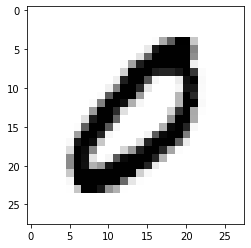

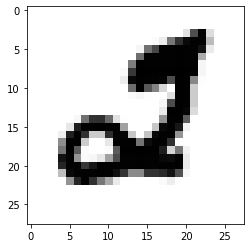

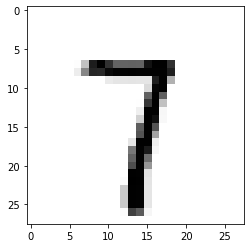

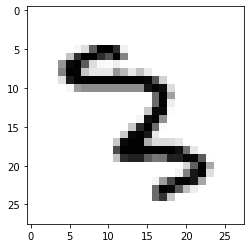

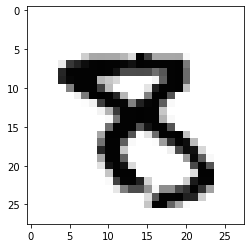

In [5]:
def display_images(images):
    images = images.detach().numpy()

    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='Greys')
        plt.show()
        
display_images(train_data_pixels[:5])

In [6]:
def KL_with_gaussian_prior(mu, log_sigma_squared):
    return - .5 * torch.sum(1 + log_sigma_squared - mu**2 - torch.exp(log_sigma_squared), 1)

In [7]:
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.mean_out = nn.Linear(hidden_dim, output_dim)
        self.logvar_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = self.fc1(batch)
        act = F.relu(hid)
        mean = self.mean_out(act)
        logvar = self.logvar_out(act)
        
        return (mean, logvar)

In [20]:
from torch.distributions.multivariate_normal import MultivariateNormal

def sample_prior(n_features, n_samples=1):
    return MultivariateNormal(torch.zeros(n_features), torch.eye(n_features)).sample((n_samples,))

class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.mean_out = nn.Linear(hidden_dim, output_dim)
        self.input_dim = input_dim
        
       
    def forward(self, batch):
        hid = self.fc1(batch)
        act = F.relu(hid)
        
        return torch.sigmoid(self.mean_out(act))
    
    def sample_distributions(self, n_samples):
        z = sample_prior(self.input_dim, n_samples)
        return self(z)

In [21]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.input_dim = input_dim
    
    def forward(self, batch):
        hid = self.fc1(batch)
        act = F.relu(hid)
        
        out = self.out(act).view(-1)
        
        return torch.sigmoid(out)

In [22]:
def sample_images(decoder, n_samples, argmax=False):
    means = decoder.sample_distributions(n_samples)

    if argmax:
        return means
    else:
        var = 0.1**2
        x = means + var * torch.randn_like(means)
        return x

In [36]:
real_label = 1 # encoding comes form p(z)
fake_label = 0 # encoding comes from q(z) (Encoder generated)

In [24]:
def get_loss(D, encodings, label):
    disc_guesses = D(encodings)
    targets = torch.full_like(disc_guesses, label)
    d_loss = F.binary_cross_entropy(disc_guesses, targets)
    D_mean = torch.mean(disc_guesses)
    return d_loss, D_mean


def encoder_adv_loss(D, encoder_encodings):
    return get_loss(D, encoder_encodings, real_label)[0]


def discriminator_loss(D, p_z_encodings, encoder_encodings):    
    return (*get_loss(D, p_z_encodings, real_label), *get_loss(D, encoder_encodings, fake_label))

In [35]:
dim_input = 28*28
latent_dim = 2
hidden_disc_dim = 10
hidden_dim = 400
n_epoch = 50
batch_dim = 256
adv_loss_weight = 100

encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input)
discriminator = Discriminator(latent_dim, hidden_disc_dim)

vae_optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
disc_optimizer = torch.optim.Adam(discriminator.parameters())

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0
    epoch_adv_loss = 0
    epoch_disc_loss = 0
    real_means = []
    fake_means = []

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim):  
        discriminator.zero_grad()
        vae_optimizer.zero_grad()
        
        # 1. Generate encodings using the Encoder and reparam. trick
        batch = train_data_pixels[i:i+batch_dim]
        mu, log_sigma_squared = encoder(batch)
        
        real_samples = sample_prior(latent_dim, n_samples=batch_dim)
        
        eyes = torch.diag_embed(torch.ones_like(log_sigma_squared))
        epsilon = MultivariateNormal(torch.zeros_like(mu), eyes).sample()
        z = mu + epsilon*torch.exp(log_sigma_squared)
        loss_real, mean_real, loss_fake, mean_fake = discriminator_loss(discriminator, real_samples.detach(), z.detach())
        disc_loss = loss_real + loss_fake
        disc_loss.backward()
        disc_optimizer.step()
        
        epoch_disc_loss += disc_loss.item()
        real_means.append(mean_real.item())
        fake_means.append(mean_fake.item())
        
        # 2. Calculate encoder adversarial loss
        enc_adv_loss = encoder_adv_loss(discriminator, z)
        epoch_adv_loss += enc_adv_loss.item()
        
        # 3. Calculate VAE loss as usual (using ELBO) and add adversarial loss
        reconstruction_logits = decoder(z)
        reconstruction_loss = F.mse_loss(
            reconstruction_logits,
            batch,
            reduction="none"
        )
        
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)

        elbo = -reconstruction_loss.sum(1) - kl_div
        
        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        loss = -elbo.mean() + adv_loss_weight * enc_adv_loss
        loss.backward()
        

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        vae_optimizer.step()
        
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0],
        "\t",
        epoch_adv_loss / train_data_pixels.shape[0],
        "\t",
        epoch_disc_loss / train_data_pixels.shape[0],
        "\t",
        np.mean(real_means),
        "\t",
        np.mean(fake_means),        
    )

0 :	 -51.40463286621094 	 5.022246034960747 	 0.0029869530487060545 	 0.00575401328086853 	 0.43636199254162455 	 0.46895077855003126
1 :	 -41.525880078125 	 2.2568690856933595 	 0.0028295239627361296 	 0.0055000805115699766 	 0.47877366962481516 	 0.486018671825224
2 :	 -39.30984377929688 	 2.6319291622924803 	 0.0027283271861076354 	 0.005484181509017944 	 0.49256754696977384 	 0.4986888413526574
3 :	 -38.232381474609376 	 2.426652436828613 	 0.0027219530463218687 	 0.005459202439785003 	 0.49630840594062997 	 0.49940988375824324
4 :	 -37.44895178710937 	 2.36441621887207 	 0.0027168857741355894 	 0.005445916302204132 	 0.49859740569883465 	 0.5000453881767332
5 :	 -36.90107193359375 	 2.376317476196289 	 0.0027183092272281646 	 0.005437947583198547 	 0.4994181656107611 	 0.4998669131677978
6 :	 -36.436666787109374 	 2.405805153808594 	 0.002722539324760437 	 0.0054341774010658265 	 0.49936237490298796 	 0.49932684308412123
7 :	 -36.03863606445312 	 2.4414260635375977 	 0.00272538613

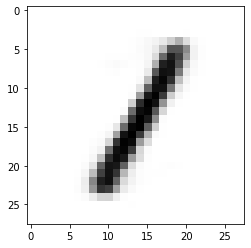

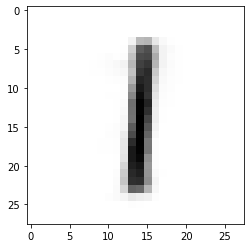

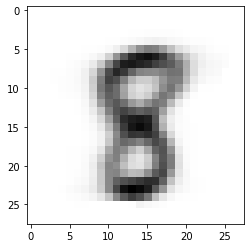

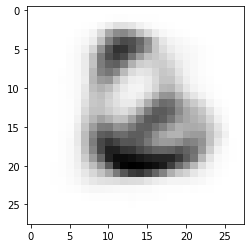

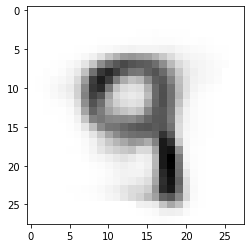

In [37]:
decoder.eval()

with torch.no_grad():
    # you can try true samples
    # or useing argmax
    samples = sample_images(decoder, 5, argmax=True)
    display_images(samples)

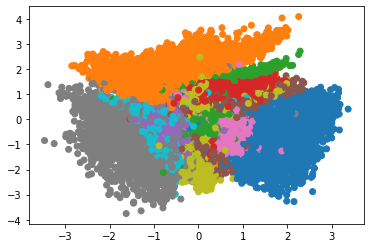

In [38]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        mu, _ = encoder(batch)
        points[i:i+batch_dim] = mu.numpy()[:,:2]

plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes / 10.)
)
plt.show()